In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
import joblib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Collection of Data**

In [2]:
legitimate_urls = pd.read_csv("./extracted_csv_files/legitimate-urls.csv")
phishing_urls = pd.read_csv("./extracted_csv_files/phishing-urls.csv")

In [3]:
legitimate_urls.head(10)
phishing_urls.head(10)

Domain  Having_@_symbol  Having_IP  \
0                     asesoresvelfit.com                0          0   
1  caixa.com.br.fgtsagendesaqueconta.com                0          0   
2                      hissoulreason.com                0          0   
3              unauthorizd.newebpage.com                0          0   
4                         133.130.103.10                0          1   
5                             dj00.co.vu                1          0   
6                         133.130.103.10                0          1   
7                    httpssicredi.esy.es                0          0   
8                            gamesaty.ga                0          0   
9                   luxuryupgradepro.com                0          0   

                                              Path  Prefix_suffix_separation  \
0                           /media/datacredito.co/                         0   
1                   /consulta8523211/principal.php                         0   
2                               /js/homepage/home/                         0   
3                                  /webapps/66fbf/                         0   
4                                             /23/                         0   
5                                            /css/                         0   
6                                       /21/logar/                         0   
7  /servico/sicredi/validarclientes/mobi/index.php                         0   
8                             /wp-content///yh/en/                         0   
9                              /ymailNew/ymailNew/                         0   

  Protocol  Redirection_//_symbol  Sub_domains  URL_Length  age_domain  \
0     http                      0            0           0           0   
1     http                      0            1           1           0   
2     http                      0            0           0           0   
3     http                      0            0           0           0   
4     http                      0            2           0           1   
5     http                      0            0           2           1   
6     http                      0            2           0           1   
7     http                      0            2           2           1   
8     http                      1            0           2           1   
9     http                      0            0           0           0   

   dns_record  domain_registration_length  http_tokens  statistical_report  \
0           0                           1            0                   0   
1           0                           1            0                   1   
2           0                           1            0                   0   
3           0                           1            0                   1   
4           0                           1            0                   0   
5           1                           1            0                   1   
6           0                           1            0                   0   
7           1                           1            1                   1   
8           0                           1            0                   0   
9           0                           1            0                   0   

   tiny_url  web_traffic  label  
0         1            1      1  
1         0            1      1  
2         0            1      1  
3         0            1      1  
4         0            1      1  
5         0            0      1  
6         0            1      1  
7         0            1      1  
8         0            1      1  
9         0            1      1

## Data PreProcessing
#### Data is in two data frames so we merge them to make one dataframe
Note: two dataframes has same column names

In [4]:
urls = legitimate_urls.append(phishing_urls)

In [5]:
urls.head(5)

Domain  Having_@_symbol  Having_IP  \
0  www.liquidgeneration.com                0          0   
1       www.onlineanime.org                0          0   
2       www.ceres.dti.ne.jp                0          0   
3            www.galeon.com                0          0   
4       www.fanworkrecs.com                0          0   

                          Path  Prefix_suffix_separation Protocol  \
0                            /                         0     http   
1                            /                         0     http   
2  /~nekoi/senno/senfirst.html                         0     http   
3                        /kmh/                         0     http   
4                            /                         0     http   

   Redirection_//_symbol  Sub_domains  URL_Length  age_domain  dns_record  \
0                      0            0           0           0           0   
1                      0            0           0           0           0   
2                      0            1           0           1           0   
3                      0            0           0           0           0   
4                      0            0           0           1           1   

   domain_registration_length  http_tokens  statistical_report  tiny_url  \
0                           1            0                   0         0   
1                           1            0                   1         0   
2                           1            0                   0         0   
3                           0            0                   0         0   
4                           1            0                   1         0   

   web_traffic  label  
0            2      0  
1            1      0  
2            0      0  
3            0      0  
4            1      0

#### Removing Unnecessary columns

In [6]:
urls = urls.drop(urls.columns[[0,3,5]],axis=1)
urls.columns

Index(['Having_@_symbol', 'Having_IP', 'Prefix_suffix_separation',
       'Redirection_//_symbol', 'Sub_domains', 'URL_Length', 'age_domain',
       'dns_record', 'domain_registration_length', 'http_tokens',
       'statistical_report', 'tiny_url', 'web_traffic', 'label'],
      dtype='object')

#### Since we merged two dataframes top 1000 rows will have legitimate urls and bottom 1000 rows will have phishing urls. So if we split the data now and create a model for it will overfit so we need to shuffle the rows before splitting the data into training set and test set

In [7]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
urls = urls.sample(frac=1).reset_index(drop=True)

In [8]:
urls.head(5)

Having_@_symbol  Having_IP  Prefix_suffix_separation  \
0                0          0                         0   
1                0          0                         0   
2                0          0                         0   
3                0          0                         0   
4                0          0                         0   

   Redirection_//_symbol  Sub_domains  URL_Length  age_domain  dns_record  \
0                      0            2           0           0           0   
1                      0            2           0           0           0   
2                      0            2           0           0           0   
3                      0            0           0           0           0   
4                      0            0           0           1           0   

   domain_registration_length  http_tokens  statistical_report  tiny_url  \
0                           1            0                   0         0   
1                           1            0                   0         0   
2                           1            0                   1         0   
3                           1            0                   0         0   
4                           1            0                   0         0   

   web_traffic  label  
0            2      0  
1            2      0  
2            1      0  
3            2      0  
4            0      0

### correlation analysis

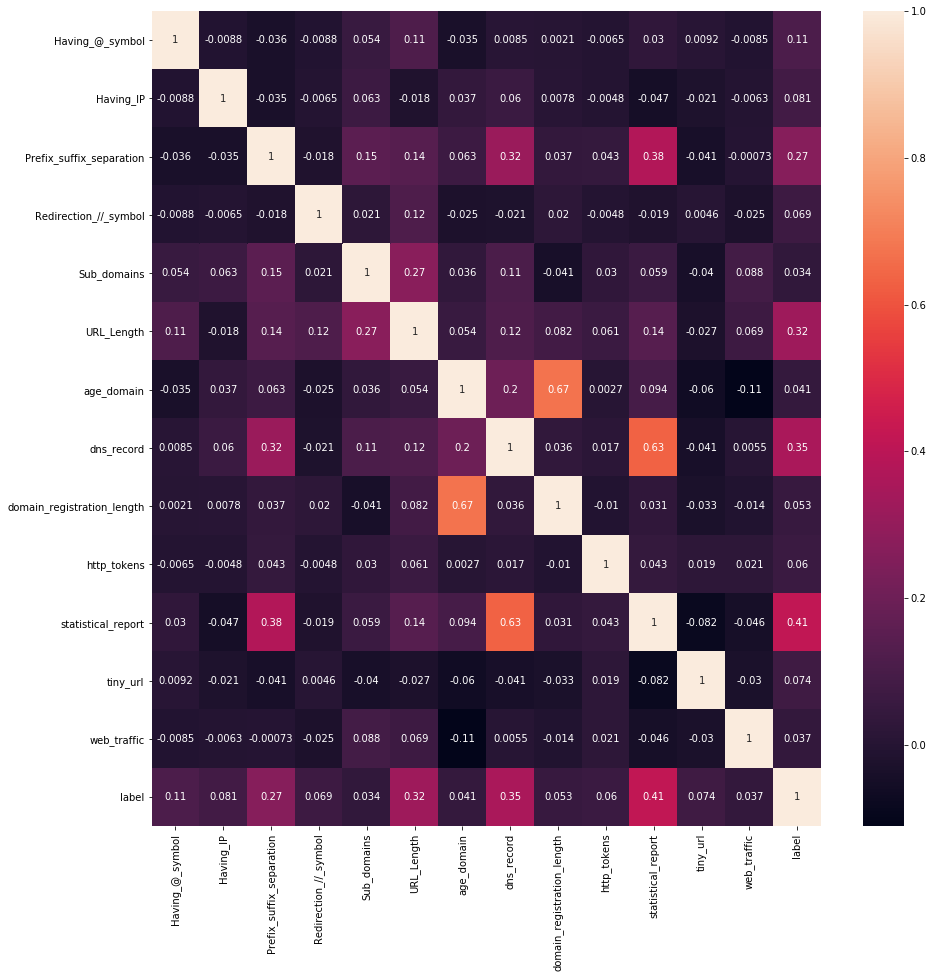

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(urls.corr(),annot=True)

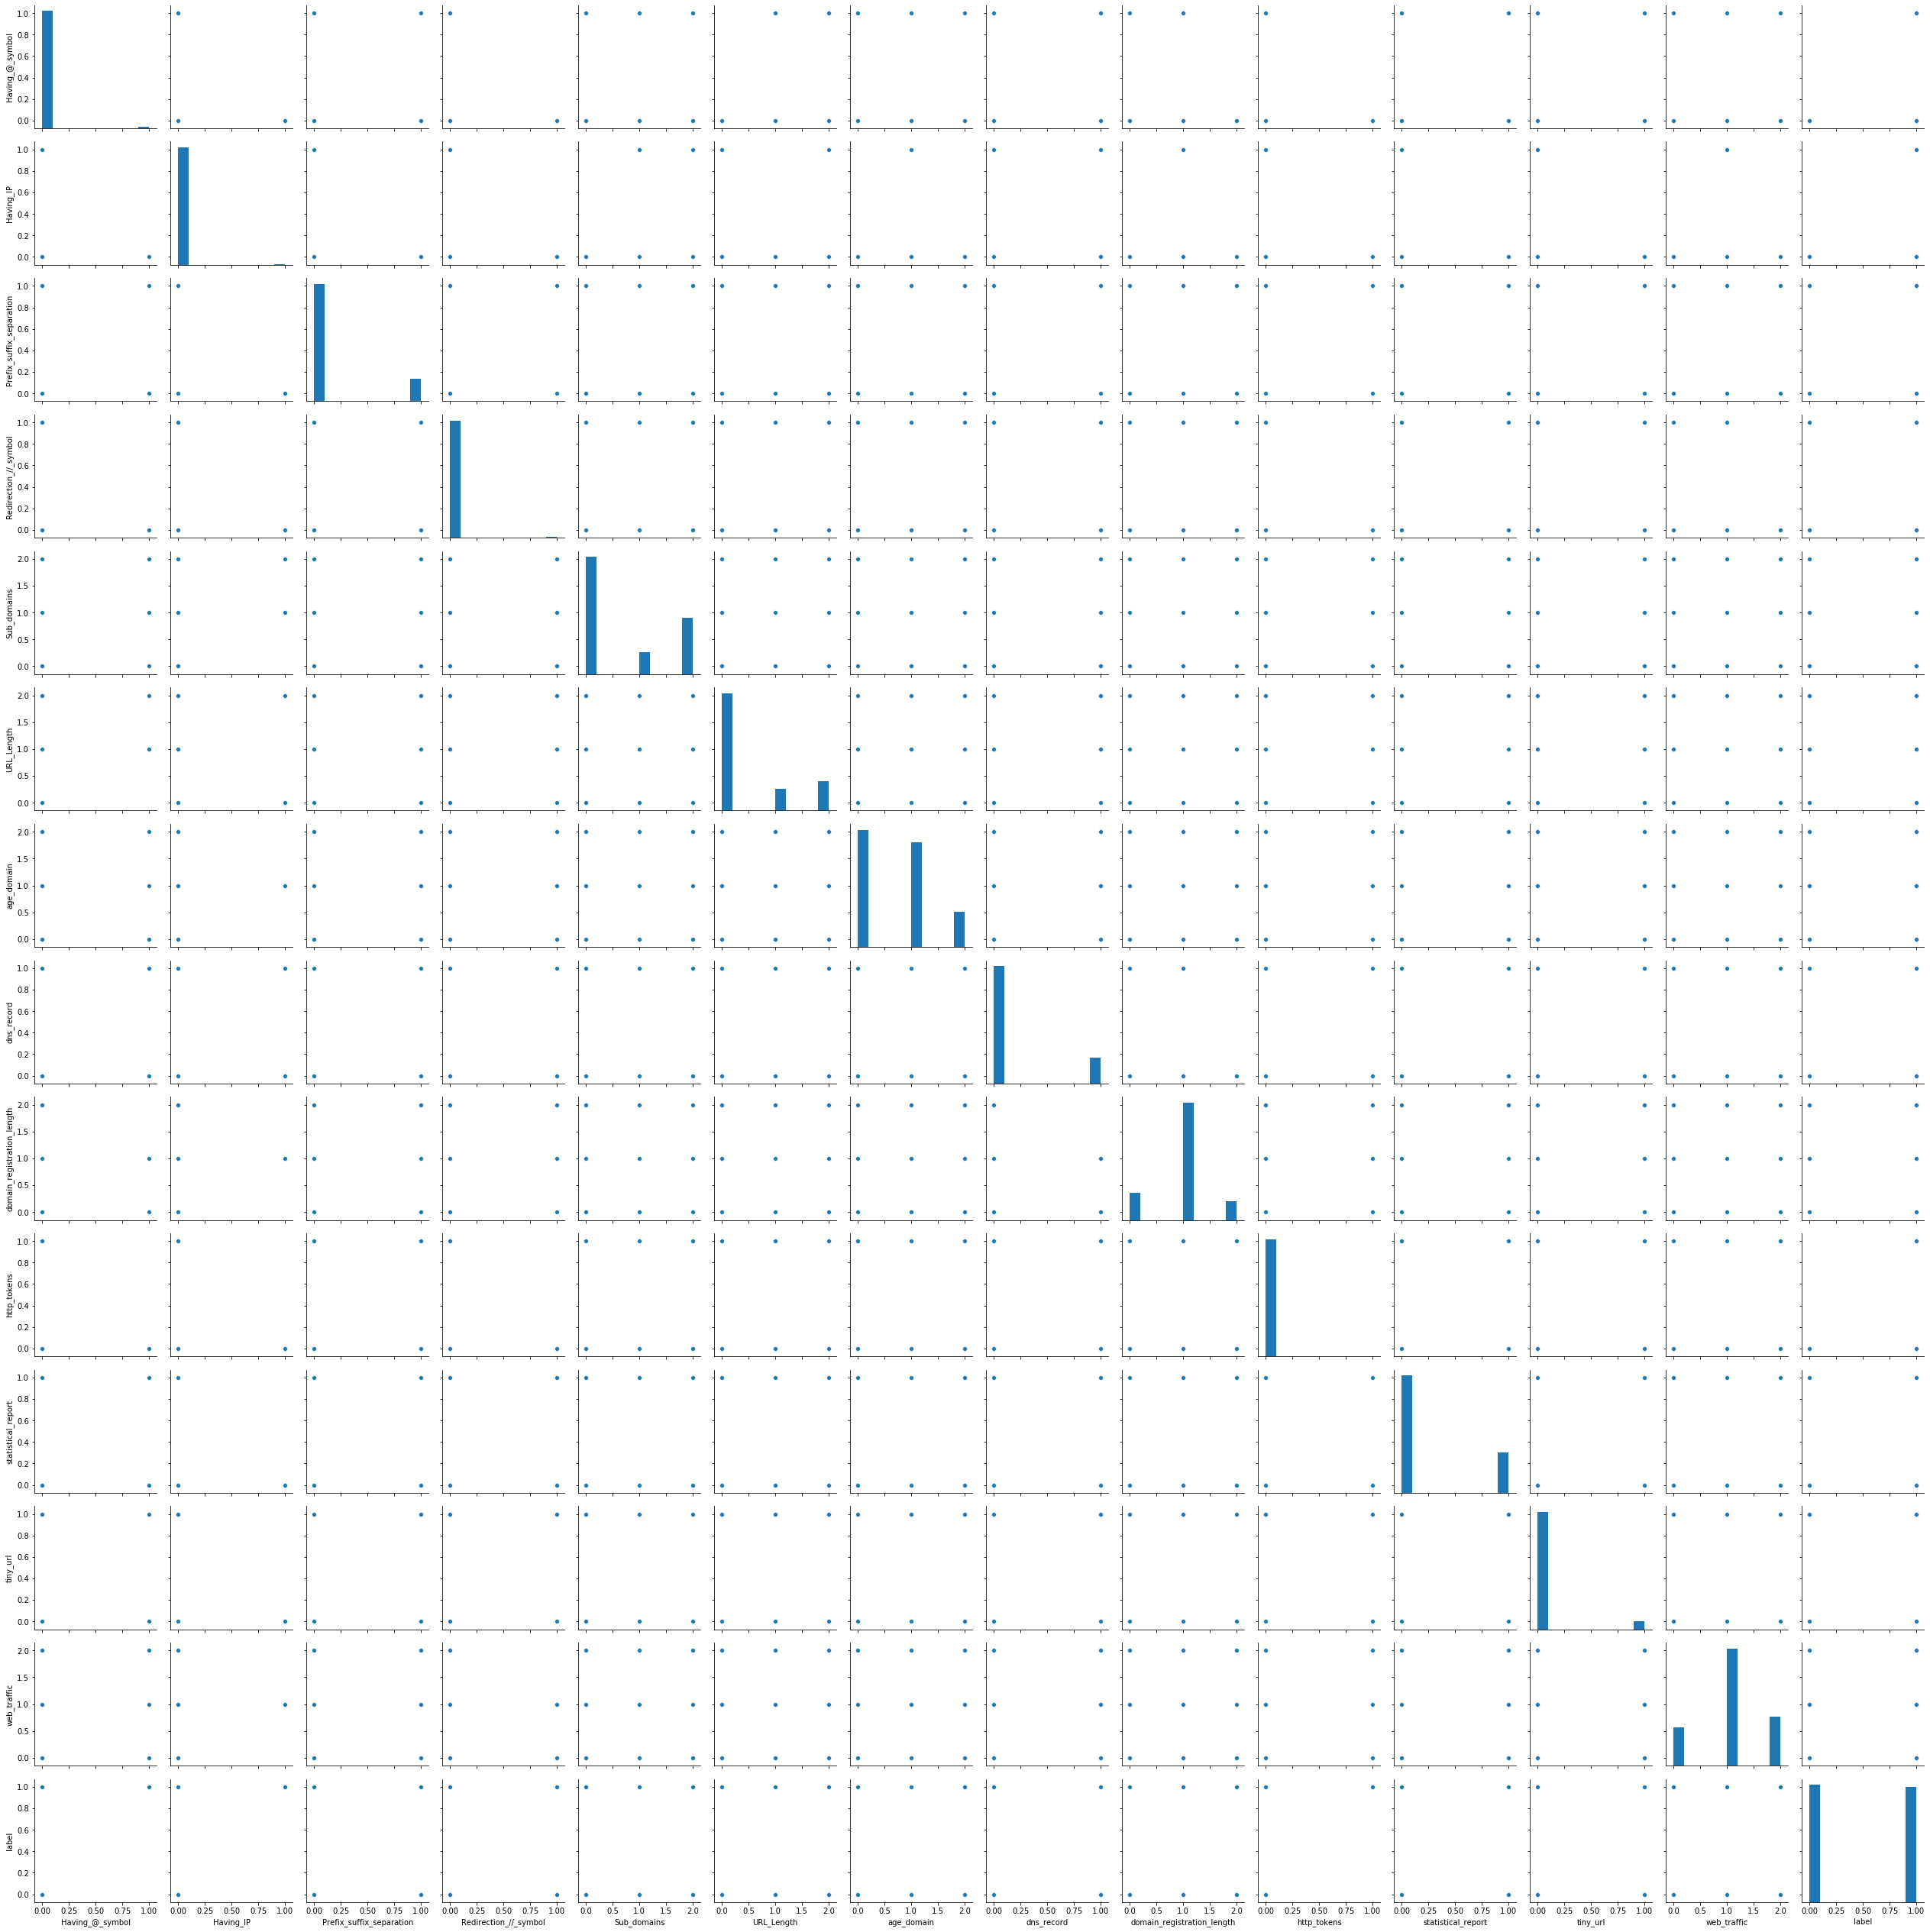

In [10]:
sns.pairplot(urls)
# urls.describe()

#### Removing class variable from the dataset

In [11]:
urls_without_labels = urls.drop('label',axis=1)
labels = urls['label']

#### splitting the data into train data and test data

Dividing the data in the ratio of 70:30 [train_data:test_data]

In [12]:
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(urls_without_labels, labels, test_size=0.20, random_state=110)

In [13]:
print(len(data_train),len(data_test),len(labels_train),len(labels_test))

1612 403 1612 403


#### checking the split of labels in train and test data

The split should be in equal proportion for both classes

Phishing - 1

Legitimate - 0


In [14]:
#initially checking the split of labels_train data 
labels_train.value_counts()

1    816
0    796
Name: label, dtype: int64

By above results it is shown that the split of both classes are almost equal!

Testing the same for labels of test data also

In [15]:
#checking the split for labels_test data
labels_test.value_counts()

0    221
1    182
Name: label, dtype: int64

as the split is almost in equal proportion we can train the model

#### General train

In [17]:
models=[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),
       GradientBoostingClassifier(),SVC(), xgb.XGBClassifier(), lgb.LGBMClassifier()]
# evaluate models by using cross-validation
names=['KNN','LR','NB','Tree','RF','GDBT','SVM', 'xgb', 'lgb']
for name, model in zip(names,models):
    score=cross_val_score(model, data_train, labels_train, cv=5)
    print("{}:{},{}".format(name,score.mean(),score.std()))

KNN:0.8033459608099532,0.016878597059974937
LR:0.7326288867949926,0.028262457441188327
NB:0.5179970386323867,0.005081462260386536
Tree:0.8281618368171066,0.0038022556972699406
RF:0.8262984827798396,0.010454954013939994
GDBT:0.8294079187739168,0.007769328977988235
SVM:0.8132703882468318,0.009781922122429842
xgb:0.8244466665384689,0.007111835891130027
lgb:0.8207238043959004,0.0076024513022830325


#### KNN

In [23]:
kNN_classifier = KNeighborsClassifier()
param_dist = {'n_neighbors':range(1,100)}
grid = RandomizedSearchCV(kNN_classifier, param_dist, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid.fit(data_train, labels_train)
best_estimator = grid.best_estimator_
print(best_estimator)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                     weights='uniform')


[[197  24]
 [ 45 137]]
0.8287841191066998


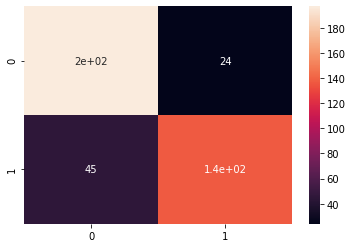

In [24]:
kNN_classifier = KNeighborsClassifier(n_neighbors=26)
kNN_classifier.fit(data_train, labels_train)
kNN_predict = kNN_classifier.predict(data_test)
cmKNN = confusion_matrix(labels_test, kNN_predict)
print(cmKNN)
print(accuracy_score(labels_test, kNN_predict))
sns.heatmap(cmKNN, annot=True)

#### SVM

In [26]:
svm_classifier = SVC()
param_dist = {'C': np.linspace(0.01, 50, 100),
             'gamma': np.linspace(0.01, 50, 100)}
grid = RandomizedSearchCV(svm_classifier, param_dist, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid.fit(data_train, labels_train)
best_estimator = grid.best_estimator_
print(best_estimator)

SVC(C=24.752525252525253, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=2.5347474747474745, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


[[188  33]
 [ 34 148]]
0.8337468982630273


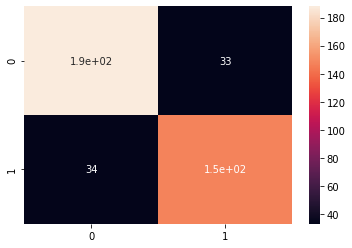

In [28]:
svm_classifier = SVC(C=24.75, gamma=2.53)
svm_classifier.fit(data_train, labels_train)
SVC_predict = svm_classifier.predict(data_test)
cmSVC = confusion_matrix(labels_test, SVC_predict)
print(cmSVC)
print(accuracy_score(labels_test, SVC_predict))
sns.heatmap(cmSVC, annot=True)

print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, SVC_predict), recall_score(labels_test, SVC_predict)))

fpr, tpr, thresholds = roc_curve(labels_test, xgb_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmXgb, annot=True)

#### RF

In [23]:
RF = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200,stop = 2000,num = 10)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_depth = [5,8,10]
max_features = ['auto','sqrt']
bootstrap = [True,False]
random_params_group = {'n_estimators':n_estimators,
                      'min_samples_split':min_samples_split,
                      'min_samples_leaf':min_samples_leaf,
                      'max_depth':max_depth,
                      'max_features':max_features,
                      'bootstrap':bootstrap}
random_model =RandomizedSearchCV(RF,param_distributions = random_params_group, n_iter = 100,
scoring = 'accuracy', verbose = 2, n_jobs = -1, cv = 10, random_state = 0)
random_model.fit(data_train, labels_train)
best_estimator = random_model.best_estimator_
print(best_estimator)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [24]:
RF_classifier = RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_split=2, n_estimators=1600)
RF_classifier.fit(data_train, labels_train)
RF_predict = RF_classifier.predict(data_test)
cmRF = confusion_matrix(labels_test, RF_predict)
print(cmRF)
accuracy_score(labels_test, RF_predict)

[[181  20]
 [ 46 156]]


0.8362282878411911

#### xgboost

In [29]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

}
xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = RandomizedSearchCV(xlf, param_distributions=parameters, scoring='accuracy', cv=5)
gsearch.fit(data_train, labels_train)

print("best score: ",gsearch.best_score_)
print("best parameters: ")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

best score:  0.8337422840989943
best parameters: 
	colsample_bytree: 0.6
	learning_rate: 0.15
	max_delta_step: 2
	max_depth: 25
	min_child_weight: 2
	n_estimators: 2000
	reg_alpha: 0.25
	reg_lambda: 0.2
	scale_pos_weight: 0.6
	subsample: 0.6


[[197  24]
 [ 38 144]]
AC and RS is: 0.8461538461538461 and 0.7912087912087912


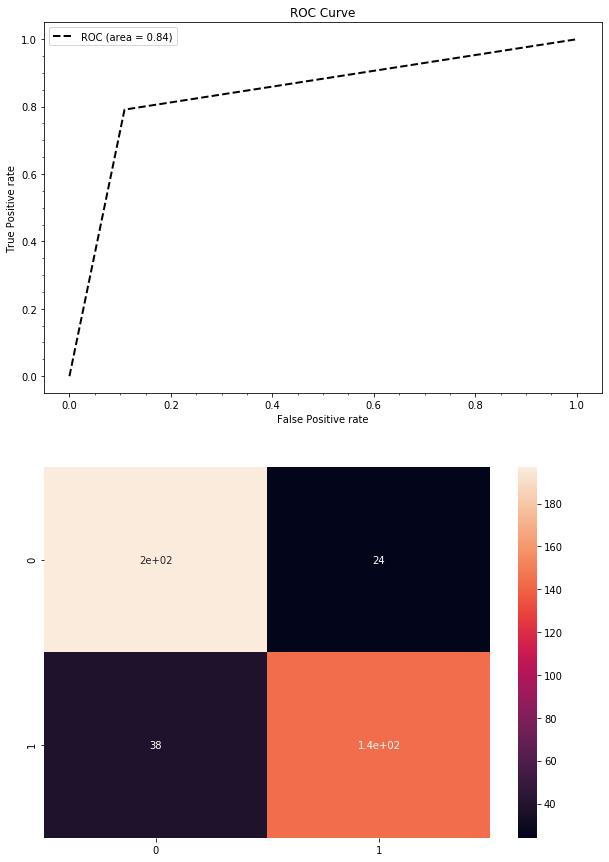

In [51]:
xgb_classifier = xgb.XGBClassifier(max_depth=25,
            learning_rate=0.15,
            n_estimators=2000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=0,
            max_delta_step=2,
            subsample=0.6,
            colsample_bytree=0.6,
            colsample_bylevel=1,
            reg_alpha=0.25,
            reg_lambda=0.2,
            scale_pos_weight=0.6,
            seed=1440,
            missing=None)

xgb_classifier.fit(data_train, labels_train)
xgb_predict = xgb_classifier.predict(data_test)
cmXgb = confusion_matrix(labels_test, xgb_predict)
print(cmXgb)
print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, xgb_predict), recall_score(labels_test, xgb_predict)))

fpr, tpr, thresholds = roc_curve(labels_test, xgb_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmXgb, annot=True)

### lightgbm

fold 1
Training until validation scores don't improve for 600 rounds
[20]	training's binary_logloss: 0.522797	training's auc: 0.903457	valid_1's binary_logloss: 0.552948	valid_1's auc: 0.861344
[40]	training's binary_logloss: 0.44864	training's auc: 0.907976	valid_1's binary_logloss: 0.494438	valid_1's auc: 0.868493
[60]	training's binary_logloss: 0.41172	training's auc: 0.911082	valid_1's binary_logloss: 0.469869	valid_1's auc: 0.870163
[80]	training's binary_logloss: 0.388459	training's auc: 0.914051	valid_1's binary_logloss: 0.458183	valid_1's auc: 0.87331
[100]	training's binary_logloss: 0.377346	training's auc: 0.916317	valid_1's binary_logloss: 0.453822	valid_1's auc: 0.873893
[120]	training's binary_logloss: 0.370302	training's auc: 0.918483	valid_1's binary_logloss: 0.451295	valid_1's auc: 0.876127
[140]	training's binary_logloss: 0.364574	training's auc: 0.920663	valid_1's binary_logloss: 0.451345	valid_1's auc: 0.875738
[160]	training's binary_logloss: 0.359822	training's auc

[660]	training's binary_logloss: 0.351273	training's auc: 0.919534	valid_1's binary_logloss: 0.359644	valid_1's auc: 0.917859
[680]	training's binary_logloss: 0.350707	training's auc: 0.91963	valid_1's binary_logloss: 0.358604	valid_1's auc: 0.918589
[700]	training's binary_logloss: 0.350385	training's auc: 0.919567	valid_1's binary_logloss: 0.357869	valid_1's auc: 0.917935
[720]	training's binary_logloss: 0.349891	training's auc: 0.920251	valid_1's binary_logloss: 0.358253	valid_1's auc: 0.918051
[740]	training's binary_logloss: 0.349465	training's auc: 0.920651	valid_1's binary_logloss: 0.358056	valid_1's auc: 0.919243
[760]	training's binary_logloss: 0.349003	training's auc: 0.920612	valid_1's binary_logloss: 0.358055	valid_1's auc: 0.919166
[780]	training's binary_logloss: 0.348479	training's auc: 0.920923	valid_1's binary_logloss: 0.358116	valid_1's auc: 0.919243
[800]	training's binary_logloss: 0.348158	training's auc: 0.921002	valid_1's binary_logloss: 0.35801	valid_1's auc: 0.9

fold 4
Training until validation scores don't improve for 600 rounds
[20]	training's binary_logloss: 0.536721	training's auc: 0.892386	valid_1's binary_logloss: 0.526998	valid_1's auc: 0.903286
[40]	training's binary_logloss: 0.465112	training's auc: 0.897666	valid_1's binary_logloss: 0.452635	valid_1's auc: 0.906182
[60]	training's binary_logloss: 0.427472	training's auc: 0.902174	valid_1's binary_logloss: 0.416657	valid_1's auc: 0.907939
[80]	training's binary_logloss: 0.40551	training's auc: 0.905864	valid_1's binary_logloss: 0.396467	valid_1's auc: 0.907437
[100]	training's binary_logloss: 0.394397	training's auc: 0.90747	valid_1's binary_logloss: 0.385612	valid_1's auc: 0.908519
[120]	training's binary_logloss: 0.387368	training's auc: 0.910362	valid_1's binary_logloss: 0.378986	valid_1's auc: 0.911917
[140]	training's binary_logloss: 0.381243	training's auc: 0.911629	valid_1's binary_logloss: 0.374023	valid_1's auc: 0.913655
[160]	training's binary_logloss: 0.376135	training's au

[600]	training's binary_logloss: 0.346385	training's auc: 0.924256	valid_1's binary_logloss: 0.380762	valid_1's auc: 0.906966
[620]	training's binary_logloss: 0.345662	training's auc: 0.924159	valid_1's binary_logloss: 0.381584	valid_1's auc: 0.906192
[640]	training's binary_logloss: 0.345019	training's auc: 0.924486	valid_1's binary_logloss: 0.38258	valid_1's auc: 0.905457
[660]	training's binary_logloss: 0.344266	training's auc: 0.924561	valid_1's binary_logloss: 0.382486	valid_1's auc: 0.905108
[680]	training's binary_logloss: 0.343579	training's auc: 0.924748	valid_1's binary_logloss: 0.381857	valid_1's auc: 0.905263
[700]	training's binary_logloss: 0.343077	training's auc: 0.924924	valid_1's binary_logloss: 0.381351	valid_1's auc: 0.905495
[720]	training's binary_logloss: 0.342754	training's auc: 0.925224	valid_1's binary_logloss: 0.381104	valid_1's auc: 0.907546
[740]	training's binary_logloss: 0.342234	training's auc: 0.925104	valid_1's binary_logloss: 0.381289	valid_1's auc: 0.

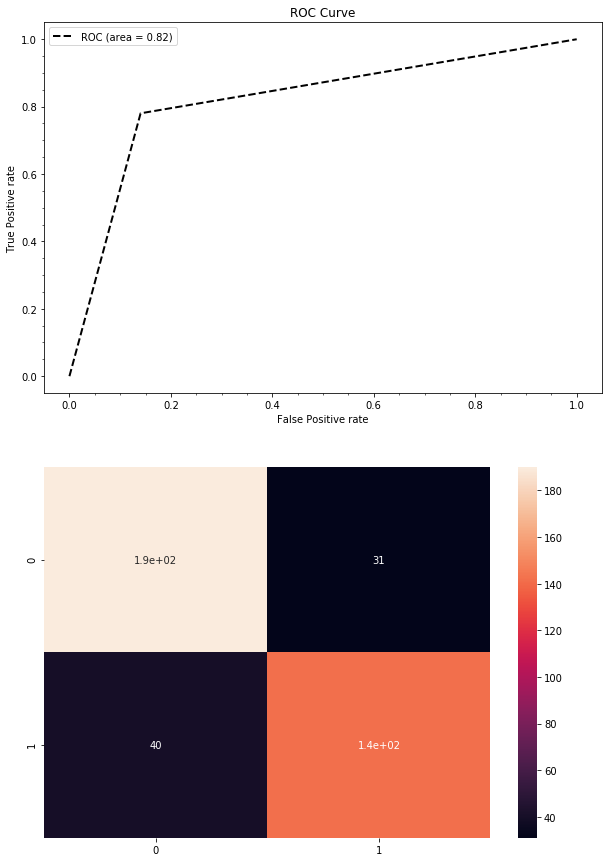

In [47]:
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2021, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2021)
prob_oof = np.zeros((data_train.shape[0], ))
test_pred_prob = np.zeros((data_test.shape[0], ))


## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(data_train.iloc[trn_idx], label=labels_train.iloc[trn_idx])
    val_data = lgb.Dataset(data_train.iloc[val_idx], label=labels_train.iloc[val_idx])


    clf = lgb.train(params,
                    trn_data,
                    num_boost_round=1000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=20,
                    early_stopping_rounds=600)
    prob_oof[val_idx] = clf.predict(data_train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = urls_without_labels.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(data_test[urls_without_labels.columns], num_iteration=clf.best_iteration) / folds.n_splits

threshold = 0.5
for pred in test_pred_prob:
    result = 1 if pred > threshold else 0
    
# save model  
joblib.dump(clf, "lgb_model.pkl")

predicts = clf.predict(data_test)
lgb_predict = []
for pred in predicts:
    if pred > threshold: 
        lgb_predict.append(1)
    else:
        lgb_predict.append(0)

print('\n This following info is confusion matrix and accuracy score:')
cmlgb = confusion_matrix(labels_test, lgb_predict)
print(cmlgb)
print('AC and RS is:'.format(accuracy_score(labels_test, lgb_predict), recall_score(labels_test, lgb_predict)))
fpr, tpr, thresholds = roc_curve(labels_test, lgb_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmlgb, annot=True)

<Figure size 864x432 with 0 Axes>

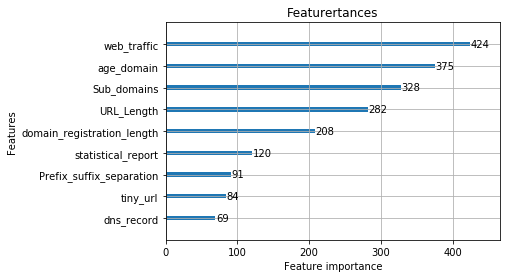

In [34]:
plt.figure(figsize=(12,6))
lgb.plot_importance(clf, max_num_features=30)
plt.title("Featurertances")
plt.show()

### try stacking model

In [51]:
# get a stacking ensemble of models
def get_stacking():
    level0 = []
    level0.append(('xgb', xgb.XGBClassifier()))
    level0.append(('RF', RandomForestClassifier()))
    level0.append(('SVC', SVC()))
    level0.append(('knn', KNeighborsClassifier()))
    level1 = GradientBoostingClassifier()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
    return model

stack_model = get_stacking()
stack_model.fit(data_train, labels_train)
stack_model_predict = stack_model.predict(data_test)
cmStack = confusion_matrix(labels_test, stack_model_predict)
print(cmStack)
accuracy_score(labels_test, stack_model_predict)

[[180  21]
 [ 45 157]]


0.8362282878411911

### save model

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=15,
            learning_rate=0.01,
            n_estimators=2000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=0,
            max_delta_step=0,
            subsample=0.95,
            colsample_bytree=0.6,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=0.6,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

xgb_classifier.fit(data_train, labels_train)
joblib.dump(xgb_classifier, "xgb_model.pkl")

# Dnn

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## data preprocess

In [43]:
legitimate_urls = pd.read_csv("./extracted_csv_files/legitimate_urls.csv")
phishing_urls = pd.read_csv("./extracted_csv_files/phishing-urls.csv")
urls = legitimate_urls.append(phishing_urls)
urls = urls.drop(urls.columns[[0,3,5]],axis=1)
urls = legitimate_urls.drop(urls.columns[[0]],axis=1)
urls_without_labels = urls.drop('label',axis=1)
labels = urls['label']
data_train, data_test, labels_train, labels_test = train_test_split(urls_without_labels, labels, test_size=0.20, random_state=42)


data_train = data_train.values
labels_train = labels_train.values[:, np.newaxis]

data_test = data_test.values
labels_test = labels_test.values[:, np.newaxis]

class myData(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = np.asarray(data)
        self.label = np.asarray(label)
    
    def __getitem__(self, index):
        txt = torch.from_numpy(self.data[index])
        label = torch.from_numpy(self.label[index])
        return txt, label #返回标签
 
    def __len__(self):
        return len(self.data)

train_dataset = myData(data=data_train, label=labels_train)
test_dataset = myData(data=data_test, label=labels_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
print('Training data is {} \nTest data is {}'.format(train_dataset.__len__(), test_dataset.__len__()))

FileNotFoundError: [Errno 2] File ./extracted_csv_files/legitimate_urls.csv does not exist: './extracted_csv_files/legitimate_urls.csv'

## define DNN structure

In [207]:
class dnn(nn.Module):
    def __init__(self):
        super(dnn, self).__init__()
        self.l1 = nn.Linear(10, 32)
        self.l2 = nn.Linear(32, 64)
        self.l3 = nn.Linear(64, 30)
        self.l4 = nn.Linear(30, 1)
#         self.l5 = nn.Linear(15, 5)
#         self.l6 = nn.Linear(5, 1)
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.dropout(x)
        x = F.relu(self.l3(x))
#         x = F.relu(self.l4(x))
#         x = self.dropout(x)
#         x = F.relu(self.l5(x))
        return self.l4(x)

In [208]:
model = dnn()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

def train(epoch):
    model.train()
    L = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = Variable(data).float(), Variable(label).float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, label)
        loss.backward()
        optimizer.step()
        L += loss.item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    return L/(batch_idx+1)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data,volatile=True).float(), Variable(target).float()
        output = model(data)
        # sum up batch loss
        test_loss += F.binary_cross_entropy_with_logits(output, target).data.item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [209]:
loss = []
for epoch in range(1, 2000):
    loss.append(train(epoch))
    test()

Train Epoch: 1 [0/76728 (0%)] Loss: 46500.289062
Train Epoch: 1 [640/76728 (1%)] Loss: nan
Train Epoch: 1 [1280/76728 (2%)] Loss: nan
Train Epoch: 1 [1920/76728 (3%)] Loss: nan
Train Epoch: 1 [2560/76728 (3%)] Loss: nan
Train Epoch: 1 [3200/76728 (4%)] Loss: nan
Train Epoch: 1 [3840/76728 (5%)] Loss: nan
Train Epoch: 1 [4480/76728 (6%)] Loss: nan
Train Epoch: 1 [5120/76728 (7%)] Loss: nan
Train Epoch: 1 [5760/76728 (8%)] Loss: nan
Train Epoch: 1 [6400/76728 (8%)] Loss: nan
Train Epoch: 1 [7040/76728 (9%)] Loss: nan
Train Epoch: 1 [7680/76728 (10%)] Loss: nan
Train Epoch: 1 [8320/76728 (11%)] Loss: nan
Train Epoch: 1 [8960/76728 (12%)] Loss: nan
Train Epoch: 1 [9600/76728 (13%)] Loss: nan
Train Epoch: 1 [10240/76728 (13%)] Loss: nan
Train Epoch: 1 [10880/76728 (14%)] Loss: nan
Train Epoch: 1 [11520/76728 (15%)] Loss: nan
Train Epoch: 1 [12160/76728 (16%)] Loss: nan
Train Epoch: 1 [12800/76728 (17%)] Loss: nan
Train Epoch: 1 [13440/76728 (18%)] Loss: nan
Train Epoch: 1 [14080/76728 (18%)

<ipython-input-208-801e388101aa>:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data,volatile=True).float(), Variable(target).float()



Test set: Average loss: nan, Accuracy: 7810/19182 (41%)

Train Epoch: 2 [0/76728 (0%)] Loss: nan
Train Epoch: 2 [640/76728 (1%)] Loss: nan
Train Epoch: 2 [1280/76728 (2%)] Loss: nan
Train Epoch: 2 [1920/76728 (3%)] Loss: nan
Train Epoch: 2 [2560/76728 (3%)] Loss: nan
Train Epoch: 2 [3200/76728 (4%)] Loss: nan
Train Epoch: 2 [3840/76728 (5%)] Loss: nan
Train Epoch: 2 [4480/76728 (6%)] Loss: nan
Train Epoch: 2 [5120/76728 (7%)] Loss: nan
Train Epoch: 2 [5760/76728 (8%)] Loss: nan
Train Epoch: 2 [6400/76728 (8%)] Loss: nan
Train Epoch: 2 [7040/76728 (9%)] Loss: nan
Train Epoch: 2 [7680/76728 (10%)] Loss: nan
Train Epoch: 2 [8320/76728 (11%)] Loss: nan
Train Epoch: 2 [8960/76728 (12%)] Loss: nan
Train Epoch: 2 [9600/76728 (13%)] Loss: nan
Train Epoch: 2 [10240/76728 (13%)] Loss: nan
Train Epoch: 2 [10880/76728 (14%)] Loss: nan
Train Epoch: 2 [11520/76728 (15%)] Loss: nan
Train Epoch: 2 [12160/76728 (16%)] Loss: nan
Train Epoch: 2 [12800/76728 (17%)] Loss: nan
Train Epoch: 2 [13440/76728 (

Train Epoch: 3 [39680/76728 (52%)] Loss: nan
Train Epoch: 3 [40320/76728 (53%)] Loss: nan
Train Epoch: 3 [40960/76728 (53%)] Loss: nan
Train Epoch: 3 [41600/76728 (54%)] Loss: nan
Train Epoch: 3 [42240/76728 (55%)] Loss: nan
Train Epoch: 3 [42880/76728 (56%)] Loss: nan
Train Epoch: 3 [43520/76728 (57%)] Loss: nan
Train Epoch: 3 [44160/76728 (58%)] Loss: nan
Train Epoch: 3 [44800/76728 (58%)] Loss: nan
Train Epoch: 3 [45440/76728 (59%)] Loss: nan
Train Epoch: 3 [46080/76728 (60%)] Loss: nan
Train Epoch: 3 [46720/76728 (61%)] Loss: nan
Train Epoch: 3 [47360/76728 (62%)] Loss: nan
Train Epoch: 3 [48000/76728 (63%)] Loss: nan
Train Epoch: 3 [48640/76728 (63%)] Loss: nan
Train Epoch: 3 [49280/76728 (64%)] Loss: nan
Train Epoch: 3 [49920/76728 (65%)] Loss: nan
Train Epoch: 3 [50560/76728 (66%)] Loss: nan
Train Epoch: 3 [51200/76728 (67%)] Loss: nan
Train Epoch: 3 [51840/76728 (68%)] Loss: nan
Train Epoch: 3 [52480/76728 (68%)] Loss: nan
Train Epoch: 3 [53120/76728 (69%)] Loss: nan
Train Epoc

Train Epoch: 5 [10240/76728 (13%)] Loss: nan
Train Epoch: 5 [10880/76728 (14%)] Loss: nan
Train Epoch: 5 [11520/76728 (15%)] Loss: nan
Train Epoch: 5 [12160/76728 (16%)] Loss: nan
Train Epoch: 5 [12800/76728 (17%)] Loss: nan
Train Epoch: 5 [13440/76728 (18%)] Loss: nan
Train Epoch: 5 [14080/76728 (18%)] Loss: nan
Train Epoch: 5 [14720/76728 (19%)] Loss: nan
Train Epoch: 5 [15360/76728 (20%)] Loss: nan
Train Epoch: 5 [16000/76728 (21%)] Loss: nan
Train Epoch: 5 [16640/76728 (22%)] Loss: nan
Train Epoch: 5 [17280/76728 (23%)] Loss: nan
Train Epoch: 5 [17920/76728 (23%)] Loss: nan
Train Epoch: 5 [18560/76728 (24%)] Loss: nan
Train Epoch: 5 [19200/76728 (25%)] Loss: nan
Train Epoch: 5 [19840/76728 (26%)] Loss: nan
Train Epoch: 5 [20480/76728 (27%)] Loss: nan
Train Epoch: 5 [21120/76728 (28%)] Loss: nan
Train Epoch: 5 [21760/76728 (28%)] Loss: nan
Train Epoch: 5 [22400/76728 (29%)] Loss: nan
Train Epoch: 5 [23040/76728 (30%)] Loss: nan
Train Epoch: 5 [23680/76728 (31%)] Loss: nan
Train Epoc

KeyboardInterrupt: 

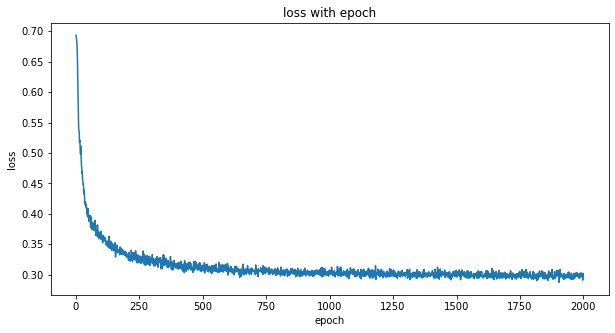

In [186]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,2000), loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss with epoch')
plt.show()